### Emulating a controller with an LSTM Network

The purpose of this exercise is to automate a temperature control process with an LSTM network. The LSTM network is trained from a PID (Proportional Integral Derivative) controller or a Model Predictive Controller (MPC). LSTM (Long Short Term Memory) networks are a special type of RNN (Recurrent Neural Network) that is structured to remember and predict based on long-term dependencies that are trained with time-series data. An LSTM repeating module has four interacting components.

<img align=left width=400px src='https://apmonitor.com/pds/uploads/Main/lstm_automation.png'>

The LSTM is trained (parameters adjusted) with an input window of prior data and minimized difference between the predicted and next measured value. Sequential methods predict just one next value based on the window of prior data. In this case, the error between the set point and measured value is the feature and the heater value is the output label.

See [Automation with LSTM Network](https://apmonitor.com/pds/index.php/Main/LSTMAutomation) for additional details.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm # Progress bar

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

# For TCLab and Limonata
import tclab
import limonata

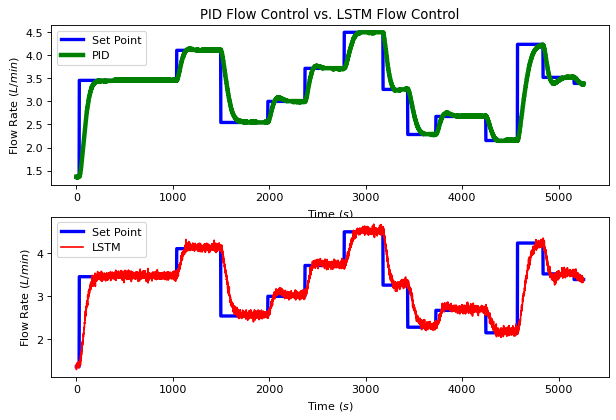

In [3]:
df = pd.read_csv(r"C:\Users\ltlee\Downloads\PID_train_data_flow.csv")

Q_PID  = df['pumpQ']
F_PID = df['F'].copy()
F_LSTM  = df['F']
Fsp    = df['Fsp']
#F_data = np.array(df['F'].copy())

noise = np.random.normal(0.025, 0.05, len(F_LSTM))
F_LSTM += noise

plt.figure(figsize = (9, 9), dpi = 80)

plt.subplot(3, 1, 1)
plt.title('PID Flow Control vs. LSTM Flow Control')
plt.plot(Fsp, 'b-', linewidth = 3, label = 'Set Point')
plt.plot(F_PID, 'g-', linewidth = 4,  label = 'PID')
plt.xlabel('Time $(s)$')
plt.ylabel('Flow Rate $(L/min)$')
plt.legend(loc = 'best')

plt.subplot(3, 1, 2)
plt.plot(Fsp, 'b-', linewidth = 3, label = 'Set Point')
plt.plot(F_LSTM, 'r-', label = 'LSTM')
plt.xlabel('Time $(s)$')
plt.ylabel('Flow Rate $(L/min)$')
plt.legend(loc = 'best')

#plt.subplot(3, 1, 3)
#plt.plot(pumpQ, 'k-')

plt.show()

### Initialize TCLab Emulator with 100x speedup

The [TCLab emulator (digital twin)](https://tclab.readthedocs.io/en/latest/notebooks/04_Emulation_of_TCLab_for_Offline_Use.html) can run faster than real-time. Use 100x speedup with the simulator. Optionally, use the TCLab to generate the training data.

In [ ]:
#speedup = 100
#TCLab = tclab.setup(connected=False, speedup = speedup)

### Program PID controller 

Apply this emulated control on the physical TCLab controller. Use the emulator for training.

In [2]:
import limonata
import time
import numpy as np
import matplotlib.pyplot as plt




# PID Parameters


Kc   = 1.52295
tauI = 0.33682 # sec
tauD = 0.0  # sec
# KI needs to be 4.521558495890757
#-----------------------------------------
# PID Controller
#-----------------------------------------

def pid(sp, pv, pv_last, ierr, dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    
    # ubias for controller (initial pump duty)
    op0 = 0 
    
    # upper and lower bounds for pump
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI*error*dt
    
    # calculate the measurement derivative
    if dt >= 1e-8:
        dpv = (pv - pv_last)/dt
    else:
        dpv = 0.0;
    
    # calculate the PID output
    P = KP*error
    I = ierr
    D = -KD*dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI*error*dt
        # clip output
        op = max(oplo, min(ophi, op))
        
    # return the controller output and PID terms
    return [op, P, I, D]

n = 600
tm = np.linspace(0, n-1, n)
lab = limonata.Limonata()
F = np.zeros(n)
Q = np.zeros(n)
SP = np.ones(n)*0
SP[10:] = 3.750
SP[100:] = 4.00
SP[200:] = 3.50
Qbias = 0.0
ierr = 0.0

print('Time (s), Pump Duty (%), Flow rate (L/min), Setpoint')
for i in range(n):
    
    F[i] = lab.F
    [Q[i], P, ierr, D] = pid(SP[i], F[i], F[max(0, i-1)], ierr, 1.0)
    lab.Q(Q[i])
    
    #if i % 1 == 0:
        
    print(f'{i}, {Q[i]:7.2f}, {F[i]:7.2f}, {SP[i]:7.2f}')
    time.sleep(1)

lab.close()

data = np.vstack((tm, Q, F, SP)).T
np.savetxt(r'C:\Users\ltlee\OneDrive\Documents\PID_control_data.csv', data, delimiter = ',', header = 'Time,Q,F,SP', comments = '')



Limonata version 0.0.0
Arduino Leonardo connected on port COM4 at 115200 baud.
Time (s), Pump Duty (%), Flow rate (L/min), Setpoint
0,    0.00,   -0.00,    0.00
1,    0.00,   -0.00,    0.00
2,    0.00,   -0.00,    0.00
3,    0.00,   -0.00,    0.00
4,    0.00,   -0.00,    0.00
5,    0.00,   -0.00,    0.00
6,    0.00,   -0.00,    0.00
7,    0.00,   -0.00,    0.00
8,    0.00,   -0.00,    0.00
9,    0.00,   -0.00,    0.00
10,   22.67,   -0.00,    3.75
11,   39.62,   -0.00,    3.75
12,   30.17,    4.37,    3.75
13,   48.55,    0.87,    3.75
14,   28.69,    6.31,    3.75
15,   55.25,   -0.00,    3.75
16,  100.00,   -5.63,    3.75
17,   39.89,    5.35,    3.75
18,   94.24,   -4.84,    3.75
19,   74.27,    4.89,    3.75
20,   94.68,    0.66,    3.75
21,   78.46,    5.66,    3.75
22,   86.87,    2.84,    3.75
23,   83.49,    4.08,    3.75
24,   86.33,    3.36,    3.75
25,   84.23,    4.00,    3.75
26,   90.29,    2.81,    3.75
27,   84.31,    4.50,    3.75
28,   87.37,    3.43,    3.75
29,   88

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\ltlee\\OneDrive\\Documents\\PID_control_data.csv'

### Sensor Tuning Tests


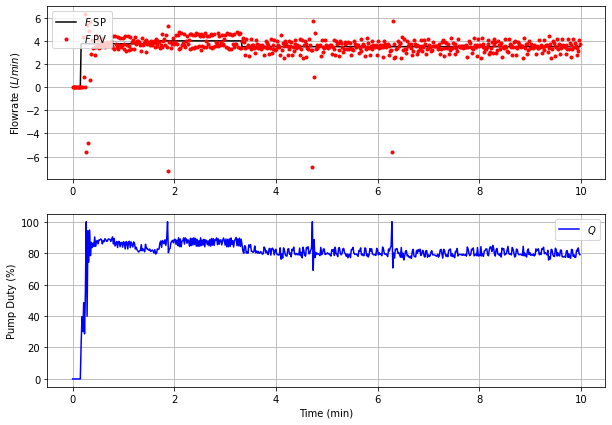

In [4]:
plt.figure(figsize = (10, 7))
ax = plt.subplot(2,1,1)
ax.grid()
plt.plot(tm/60.0, SP, 'k-', label = r'$F$ SP')
plt.plot(tm/60.0, F, 'r.', label = r'$F$ PV')
plt.ylabel(r'Flowrate ($L/min$)')
plt.legend(loc = 2)
ax = plt.subplot(2, 1, 2)
ax.grid()
plt.plot(tm/60.0, Q, 'b-', label = r'$Q$')
plt.ylabel(r'Pump Duty (%)')
plt.xlabel('Time (min)')
plt.legend(loc = 1)
plt.savefig('PID_Flow_Control_data.png')
plt.show()

In [ ]:
# Read CSV

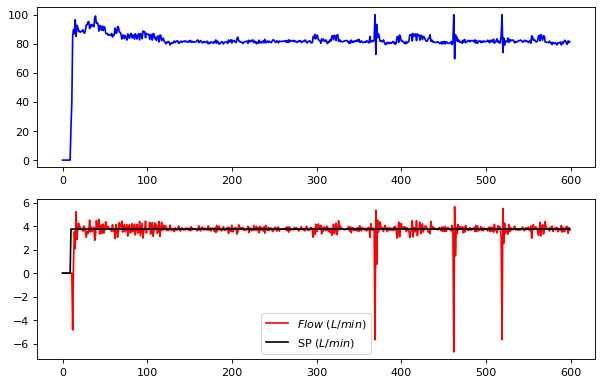

In [3]:
# Save csv file

df = pd.read_csv(r'C:\Users\ltlee\OneDrive\Documents\PID_control_data.csv')

# Plot
plt.figure(figsize = (9, 9), dpi = 80)
plt.subplot(3, 1, 1)
plt.plot(df['Q'],'b-',label='$Q_P$ (%)')
plt.subplot(3, 1, 2)
plt.plot(df['F'],'r-',label='$Flow$ $(L/min)$')
plt.plot(df['SP'],'k-',label='SP $(L/min)$')
plt.legend()
plt.savefig('PID_train.png');

### Feature engineering: create SP error feature and analyze feature importance

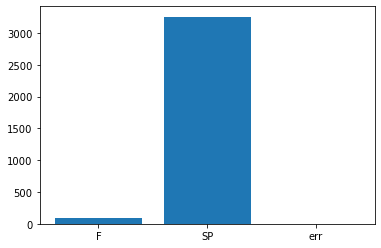

In [6]:
# Create new feature: setpoint error
df['err'] = df['SP'] - df['F']

# Load possible features
X = df[['F','SP','err']]
y = np.ravel(df[['Q']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
plt.bar(x=X.columns,height=fit.scores_);



### Feature selection, scaling, and formatting data to LSTM input format

In [7]:
X = df[['SP','err']].values
y = df[['Q']].values

# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
window = 15
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.2,shuffle=False)

### Keras LSTM 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

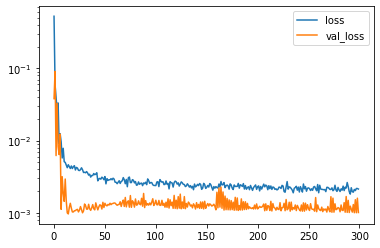

In [8]:
# Keras LSTM model
model = Sequential()

# First layer specifies input_shape and returns sequences
model.add(LSTM(units=100, return_sequences=True, 
               input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
# Dropout layer to prevent overfitting
model.add(Dropout(rate=0.1))

# Last layer doesn't return sequences (middle layers should return sequences)
model.add(LSTM(units=100))
model.add(Dropout(rate=0.1))

# Dense layer to return prediction
model.add(Dense(1))

# Compile model; adam optimizer, mse loss
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.2,
                   callbacks = [TqdmCallback(verbose=1)],#es
                   batch_size=100,
                   epochs=300)

# Plot loss and save model
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('lstm_limonata_control.h5')

### Preliminary model performance assessment

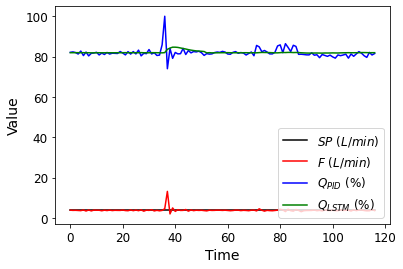

In [9]:
# Predict using LSTM
yp_s = model.predict(Xtest)

# Unscale data
Xtest_us = s_x.inverse_transform(Xtest[:,-1,:])
ytest_us = s_y.inverse_transform(ytest)
yp = s_y.inverse_transform(yp_s)

# Derive Tsp (sp) and T1 (pv) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]


# Plot SP, PID response, and LSTM response
plt.plot(sp,'k-',label='$SP$ $(L/min)$')
plt.plot(pv,'r-',label='$F$ $(L/min)$')
plt.plot(ytest_us,'b-',label='$Q_{PID}$ (%)')
plt.plot(yp,'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=12,loc='lower right')
plt.xlabel('Time',size=14)
plt.ylabel('Value',size=14)
plt.xticks(size=12)
plt.yticks(size=12);

### Generate SP data for test

Limonata version 0.0.0
Arduino Leonardo connected on port COM4 at 115200 baud.
Limonata disconnected successfully.


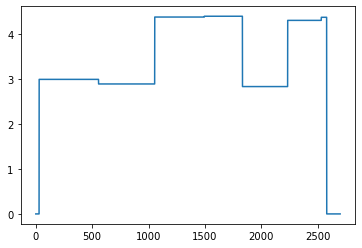

In [12]:
# Run time in minutes
run_time = 45.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
F = np.zeros(loops) # measured T (degC)
Qpid = np.zeros(loops) # Heater values for PID controller
Qlstm = np.zeros(loops) # Heater values for LSTM controller
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with limonata.Limonata() as lab:
    Fsp = np.ones(loops) * lab.F

# vary temperature setpoint
end = window + 15 # leave 1st window + 15 seconds of temp set point as room temp
while end <= loops: 
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Fsp[start:end] = random.uniform(2.75, 4.5)
    
# leave last 120 seconds as room temp
Fsp[-120:] = Fsp[0]
plt.plot(Fsp)
plt.show()

### Part A: Run the controller with the PID, but also output the LSTM for comparison

In [13]:
#-----------------------------------------
# LSTM Controller
#-----------------------------------------

def lstm(T1_m, Tsp_m):
    # Calculate error (necessary feature for LSTM input)
    err = Tsp_m - T1_m
    
    # Format data for LSTM input
    X = np.vstack((Tsp_m,err)).T
    Xs = s_x.transform(X)
    Xs = np.reshape(Xs, (1, Xs.shape[0], Xs.shape[1]))
    
    # Predict Q for controller and unscale
    Q1c_s = model.predict(Xs)
    Q1c = s_y.inverse_transform(Q1c_s)[0][0]
    
    # Ensure Q1c is between 0 and 100
    Q1c = np.clip(Q1c,0.0,100.0)
    return Q1c

In [ ]:
# Run test
with limonata.Limonata() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.F))
    #print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0
    
    start_time = 0
    prev_time = 0
    for i,t in enumerate(limonata.clock(loops)):
        tm[i] = t
        dt = t - prev_time

        # Read temperature (C)
        F[i] = lab.F

        # Integral absolute error
        iae += np.abs(Fsp[i]-F[i])

        # Calculate PID output
        [Qpid[i],P,ierr,D] = pid(Fsp[i],F[i],F[i-1],ierr,dt)

        # Write heater output (0-100)
        lab.Q(Qpid[i])
        
        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            F_m = F[i-window:i]
            Fsp_m = Fsp[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(F_m,Fsp_m)
            
        prev_time = t

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(Fsp[:i],'k-',label='SP $(L/min)$')
plt.plot(F[:i],'r-',label='$F$ $(L/min)$')
plt.plot(Qpid[:i],'b-',label='$Q_{PID}$ (%)')
plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
plt.legend(loc='upper right',fontsize=14)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)

### Part B: Run the controller with just the LSTM

In [14]:
# Run test
loops = 300
with limonata.Limonata() as lab:
    # Find current T1, T2
    print('Flow rate: {0:0.2f} L/min'.format(lab.F))
    #print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    start_time = 0
    prev_time = 0
    for i,t in enumerate(limonata.clock(loops)):
        tm[i] = t
        dt = t - prev_time

        # Read temperature (C)
        F[i] = lab.F

        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            F_m = F[i-window:i]
            Fsp_m = Fsp[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(F_m,Fsp_m)

        # Write heater output (0-100)
        lab.Q(Qlstm[i])
        
        prev_time = t

Limonata version 0.0.0
Arduino Leonardo connected on port COM4 at 115200 baud.
Flow rate: -0.00 L/min
Limonata disconnected successfully.


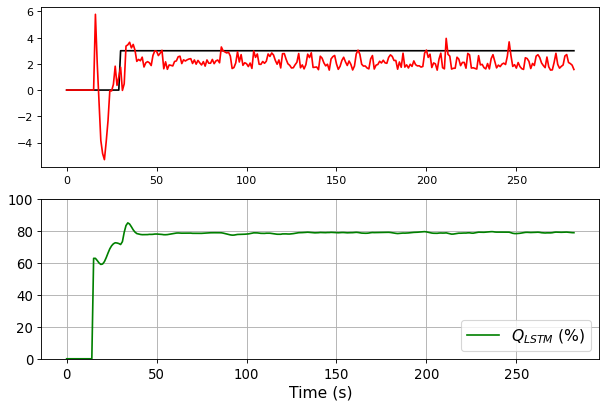

In [15]:
plt.figure(figsize = (9, 9), dpi = 80)

plt.subplot(3, 1, 1)
plt.plot(Fsp[:i],'k-',label='SP $(^oC)$')
plt.plot(F[:i],'r-',label='$T_1$ $(^oC)$')

plt.subplot(3, 1, 2)
plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=14)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

### Part C

Use the LSTM controller to control the [TCLab microcontroller](https://apmonitor.com/heat.htm) or [Emulated TCLab](https://tclab.readthedocs.io/en/latest/notebooks/04_Emulation_of_TCLab_for_Offline_Use.html) from a separate program. Demonstrate that you can [package and deploy the LSTM model](https://apmonitor.com/pds/index.php/Main/DeployMachineLearning) so that it could be used on a different computer than the training computer. The application does not necessarily need to run on a separate computer, but show that it is a separate program and independent of this training notebook.

<img align=left width=150px src='https://apmonitor.com/pds/uploads/Main/deploy_machine_learning.png'>

<img align=left width=400px src='https://apmonitor.com/pdc/uploads/Main/tclab_connect.png'>

In [ ]:
import pickle
# export model name and scaling
z = ['lstm_control.h5',s_x,s_y,window]
pickle.dump(z,open('lstm_control.pkl','wb'))